In [1]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

%matplotlib inline
import matplotlib.pyplot as plt
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

# Hyperparameters
random_seed = 123
learning_rate = 0.001
num_epochs = 10
batch_size = 256

# Architecture
num_features = 784
num_hidden_1 = 32

train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=len(test_dataset), 
                         shuffle=True)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Device: cuda:0
Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])


In [2]:

##########################
### MODEL
##########################

class Autoencoder(torch.nn.Module):

    def __init__(self, num_features):
        super(Autoencoder, self).__init__()
        
        ### ENCODER
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        
        ### DECODER
        self.linear_2 = torch.nn.Linear(num_hidden_1, num_features)
        
    def encode(self, X):
        encoded = self.linear_1(X)
        encoded = F.leaky_relu(encoded)
        return encoded
    
    def decode(self, encoded):
        logits = self.linear_2(encoded)
        decoded = torch.sigmoid(logits)
        return decoded
        
    def forward(self, X):
        encoded = self.encode(X)
        decoded = self.decode(encoded)
        return decoded

    
torch.manual_seed(random_seed)
model = Autoencoder(num_features=num_features)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [3]:
start_time = time.time()
for epoch in range(num_epochs):
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 28*28).to(device)
            
        decoded = model(features)
        cost = F.binary_cross_entropy(decoded, features)
        optimizer.zero_grad()
        
        cost.backward()
        optimizer.step()

        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
            
    print('Time elapsed: %.2f s' % ((time.time() - start_time)))
    
print('Total Training Time: %.2f s' % ((time.time() - start_time)))

Epoch: 001/010 | Batch 000/235 | Cost: 0.6983
Epoch: 001/010 | Batch 050/235 | Cost: 0.3061
Epoch: 001/010 | Batch 100/235 | Cost: 0.2516
Epoch: 001/010 | Batch 150/235 | Cost: 0.2279
Epoch: 001/010 | Batch 200/235 | Cost: 0.2045
Time elapsed: 4.68 s
Epoch: 002/010 | Batch 000/235 | Cost: 0.2004
Epoch: 002/010 | Batch 050/235 | Cost: 0.1915
Epoch: 002/010 | Batch 100/235 | Cost: 0.1810
Epoch: 002/010 | Batch 150/235 | Cost: 0.1717
Epoch: 002/010 | Batch 200/235 | Cost: 0.1621
Time elapsed: 9.26 s
Epoch: 003/010 | Batch 000/235 | Cost: 0.1607
Epoch: 003/010 | Batch 050/235 | Cost: 0.1513
Epoch: 003/010 | Batch 100/235 | Cost: 0.1477
Epoch: 003/010 | Batch 150/235 | Cost: 0.1432
Epoch: 003/010 | Batch 200/235 | Cost: 0.1428
Time elapsed: 13.79 s
Epoch: 004/010 | Batch 000/235 | Cost: 0.1375
Epoch: 004/010 | Batch 050/235 | Cost: 0.1402
Epoch: 004/010 | Batch 100/235 | Cost: 0.1340
Epoch: 004/010 | Batch 150/235 | Cost: 0.1286
Epoch: 004/010 | Batch 200/235 | Cost: 0.1246
Time elapsed: 18

In [ ]:
n_images = 15
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images]
decoded_images = decoded[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        curr_img = img[i].detach().to(torch.device('cpu'))
        ax[i].imshow(curr_img.view((image_width, image_width)), cmap='binary')

In [5]:
with torch.no_grad():
    full_train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=len(train_dataset), shuffle=False, num_workers=0
    )
    for features, _ in full_train_loader:
        features = features.view(-1, 28*28).to(device)
        encoded = model.encode(features)

In [6]:
class BaselineClassifier:
    def __init__(self, centers):
        self.centers = centers
        
    def fit(self, X, y):
        pass
        
    def predict(self, X):
        y_pred = np.argmin(euclidean_distances(X, self.centers), axis=1)
        return y_pred

In [15]:
from sklearn.neighbors import KDTree
import pandas as pd

tree = KDTree(encoded.cpu(), leaf_size=1000)   
kd_clustering = pd.DataFrame(tree.get_arrays()[2])
clustering = kd_clustering[kd_clustering['is_leaf'] == True][['idx_start', 'idx_end']]
label_list = []
for c in range(clustering.shape[0]):
    row = clustering.iloc[c]
    label_list.append(np.full(row[1] - row[0], c))
y = np.concatenate(label_list, axis=0)

encoded = encoded[tree.get_arrays()[1]]

X_clust = np.zeros((60000, 32 + 1))
X_clust[:, :-1] = encoded.cpu()
X_clust[:, -1] = y

centers = pd.DataFrame(X_clust).groupby(32).mean().values
# KD_Tree Version


In [16]:
centers.shape

(32, 32)

In [17]:
base = BaselineClassifier(centers)
dct = DecisionTreeClassifier()
nb = GaussianNB()
linear_svm = svm.SVC(kernel='linear')
radial_svm = svm.SVC(kernel='rbf')
rf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
mlp = MLPClassifier(hidden_layer_sizes=(150,100,50), activation='relu', solver='adam', max_iter=500)
classifiers = [base, nb, dct, rf, linear_svm, radial_svm, mlp]
names = ['Base Model', 'Naive Bayes', 'Decision Tree', 'Random Forest','Linear SVM', 'RBF SVM',
        'MLP']

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import euclidean_distances
X_train, X_valid, y_train, y_valid = train_test_split(encoded.cpu(), y, test_size=0.1)

In [19]:
from sklearn.metrics import accuracy_score
validations = {}
for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)
        y_pred_train = clf.predict(X_train)
        y_pred_valid = clf.predict(X_valid)
        #errors = evaluate(X_index, X_clust, X_query, clf)
        train_acc = accuracy_score(y_train, y_pred_train)
        #print(f'Train: {train_acc}')
        valid_acc = accuracy_score(y_valid, y_pred_valid)
        validations[name] = valid_acc
        #experiment[f'{name}_mean_error'] = np.mean(errors)
        #test_acc = nn_accuracy(errors)
        #experiment[f'{name}_test'] = test_acc

In [20]:
import pandas as pd 
pd.DataFrame(validations, index=[0])

,Base Model,Naive Bayes,Decision Tree,Random Forest,Linear SVM,RBF SVM,MLP
0,0.540667,0.614,0.999667,0.461,0.963,0.858833,0.867833


In [32]:
test_encoded = None
with torch.no_grad():
    for test_features, _ in test_loader:
        test_features = test_features.view(-1, 28*28).to(device)
        test_encoded = model.linear_1(test_features)
        test_encoded = F.leaky_relu(test_encoded)

In [41]:
X_query = test_encoded.cpu()
X_query.shape

torch.Size([10000, 32])

In [42]:
X_clust = np.zeros((60000, 32 + 1))
X_clust[:, :-1] = encoded.cpu()
X_clust[:, -1] = y

In [43]:
def nn_accuracy(errors):
    return (len(errors) - np.count_nonzero(errors)) / len(errors)

In [44]:
with torch.no_grad():
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='brute').fit(encoded.cpu().numpy())
    brute_n = nbrs.kneighbors(X_query.cpu().numpy(), return_distance=False)[:, 0]
    brute_nn_enc = encoded[brute_n]
    brute_nn = features[brute_n]
    #brute_nn.reshape(100, -1)

In [45]:
def evaluate(X_index, X_clust, X_query, clf, n_1=None):
    global features
    n_features = X_index.shape[1]
    
    #if n_1 == None:
    #    nbrs = NearestNeighbors(n_neighbors=1, algorithm='brute').fit(X_index)
    #    n_1 = nbrs.kneighbors(X_query, return_distance=False)

    found_n = []
    errors = []
    for i in tqdm(range(0, X_query.shape[0])):
        X_found = X_clust[X_clust[:, n_features] == np.asarray(clf.predict(X_query[i].reshape(1, -1)), dtype=np.integer)][:, :n_features]
        nbrs_2 = NearestNeighbors(n_neighbors=1, algorithm='brute').fit(X_found)
        n_2 = nbrs_2.kneighbors([X_query[i]])[1][0][0]
        found_n.append(features[np.where(encoded.cpu().detach().numpy() == X_found[n_2])[0][0]])
        error = np.sum(np.abs(X_index[n_1[i]] - X_found[n_2]))
        errors.append(error)
    return errors, X_index[n_1[i]], found_n

def nn_accuracy(errors):
    return (len(errors) - np.count_nonzero(errors)) / len(errors)

In [46]:
results = []

from tqdm.notebook import tqdm

for c in tqdm(range(len(classifiers))):
    result = {}
    clf = classifiers[c]
    result['Classifier'] = names[c]
    errors, _, found_nn = evaluate(encoded.cpu().numpy(), X_clust, X_query.numpy(), clf, brute_n)
    result['errors'] = errors
    result['Mean Absolute Error'] = np.mean(errors)
    result['Accuracy'] = nn_accuracy(errors)
    result['brute NN'] = brute_nn
    result['found NN'] = found_nn
    results.append(result)

In [47]:
import pandas as pd

results = pd.DataFrame(results, index=range(len(classifiers)))

In [48]:
results[['Classifier', 'Mean Absolute Error', 'Accuracy']]

,Classifier,Mean Absolute Error,Accuracy
0,Base Model,24.866042,0.4974
1,Naive Bayes,22.728236,0.5409
2,Decision Tree,19.486638,0.6160
3,Random Forest,33.124460,0.4066
4,Linear SVM,19.481856,0.6165
5,RBF SVM,18.128367,0.6388
6,MLP,20.321570,0.5994


In [160]:
with torch.no_grad():
    #img_svm_nn = model.decode(torch.Tensor(np.stack(results.loc[6, 'found NN'])).cuda()).detach().cpu().numpy()
    img_svm_nn = torch.stack(results.loc[6, 'found NN']).detach().cpu().numpy()

In [108]:
with torch.no_grad():
    print(model.encode(test_features[1]).detach().cpu().numpy())

[ 4.9624257  6.9231334 12.220724  12.776499   3.482287   6.0673056
 17.68702    2.3788388  5.919568   3.379711   3.2773447 18.906342
  7.11814    3.0675583  5.8250337 34.07599    7.678896   2.5562577
  1.8124633  9.454148   5.164131   5.017939   3.0488997  6.0645347
  6.034732   7.915081   6.8062534  5.1524234  3.7943997 11.822495
  9.676598  14.183282 ]


In [109]:
print(brute_nn_enc[1])

tensor([ 4.8975,  7.2078, 14.4794, 11.7908,  6.4426,  6.5339, 20.8515,  4.0543,
         8.1024,  5.1218,  3.0008, 17.3084,  7.9976,  4.3863,  5.7193, 34.7612,
         8.3218,  6.3685,  0.1977, 10.2799,  5.5994,  4.2349,  3.0225,  5.0412,
         7.6040,  5.7842,  3.7101,  5.1338,  2.0018, 12.5657, 11.9440, 14.9037],
       device='cuda:0')


In [110]:
with torch.no_grad():
    print(model.encode(brute_nn.reshape(100, -1)[1]).detach().cpu().numpy())

[ 4.8974667   7.207809   14.479401   11.790789    6.4425716   6.5338573
 20.851456    4.0542994   8.102427    5.1217546   3.0007815  17.308437
  7.9975805   4.3863106   5.7192974  34.761185    8.321768    6.3685184
  0.19768721 10.279924    5.599354    4.2348614   3.0225358   5.0411673
  7.6040497   5.7842264   3.710092    5.1338444   2.0017858  12.565742
 11.943976   14.903715  ]


In [120]:
np.stack(results.loc[6, 'found NN'])[1]

array([ 5.17773914,  5.48069239, 11.68958092, 11.67155647,  3.92955089,
        5.86740732, 13.8656435 ,  5.93747187,  3.38943291,  2.61477852,
        2.15362549, 16.66974258,  4.80136251,  5.45294189,  6.30379677,
       33.1270256 ,  9.40053844,  6.99830246,  1.55172443,  9.03614044,
        5.50749111,  3.28481674,  2.54362035,  6.00635386,  6.13347912,
        7.89640045,  6.01726627,  4.90181732,  2.44109917,  8.14559555,
       12.93159199, 13.61501694])

In [166]:
with torch.no_grad():
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='brute').fit(features.cpu().numpy())
    full_brute_nn = features[nbrs.kneighbors(test_features.cpu().numpy()[:100], return_distance=False)[:, 0]]

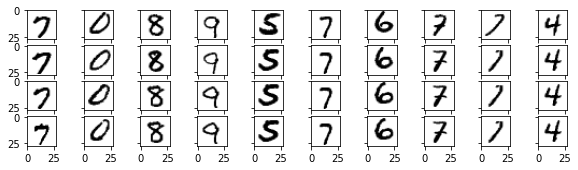

In [168]:
fig, axes = plt.subplots(nrows=4, ncols=10, 
                         sharex=True, sharey=True, figsize=(10, 2.5))

img_query = test_features.cpu().detach().numpy()
img_brute_nn = brute_nn.reshape(100, -1).cpu().numpy()
img_full_brute_nn = full_brute_nn.reshape(100, -1).cpu().numpy()
#img_svm_nn = model.cpu().decode(torch.Tensor(np.stack(results.loc[6, 'found NN'])))

for i in range(10):
    for ax, img in zip(axes, [img_query, img_full_brute_nn, img_brute_nn, img_svm_nn]):
        ax[i].imshow(img[i].reshape((image_width, image_width)), cmap='binary')